# Objective
You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a plant's species from a photo.

# Data Description
The data file names are:
- images.npy
- Label.csv

The original files are from Kaggle. Due to the large volume of data, the images were converted to images.npy file and the labels are also put into the Labels.csv.

In [1]:
PYTHONHASHSEED=0 

import numpy as np
import pandas as pd
import random

random.seed(2)
np.random.seed(597)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, AveragePooling2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(106)

from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Data

In [2]:
plant = np.load("images.npy")  # import images

In [3]:
X = plant.copy()

In [4]:
X.shape

(4750, 128, 128, 3)

- The image numpy array contains 4750 images, each image is 128 x 128 x 3.

In [5]:
X[3]   # check a random image

array([[[ 49,  48,  57],
        [ 47,  48,  58],
        [ 48,  50,  56],
        ...,
        [ 48,  47,  54],
        [ 73,  69,  82],
        [ 73,  72,  82]],

       [[ 48,  49,  59],
        [ 48,  54,  58],
        [ 72,  70,  75],
        ...,
        [ 46,  48,  54],
        [ 63,  64,  67],
        [ 69,  66,  75]],

       [[ 48,  49,  60],
        [ 60,  65,  67],
        [100, 102, 106],
        ...,
        [ 36,  39,  47],
        [ 43,  44,  52],
        [ 72,  69,  80]],

       ...,

       [[ 59,  55,  60],
        [ 60,  57,  61],
        [ 62,  59,  61],
        ...,
        [ 38,  68,  86],
        [ 50,  73,  91],
        [ 39,  60,  81]],

       [[138, 135, 138],
        [169, 166, 160],
        [173, 166, 163],
        ...,
        [ 36,  58,  77],
        [ 37,  57,  83],
        [ 30,  51,  73]],

       [[121, 115, 120],
        [145, 141, 143],
        [140, 133, 135],
        ...,
        [ 33,  56,  62],
        [ 64,  80,  87],
        [ 53,  74,  85]]

In [6]:
labels = pd.read_csv("Labels.csv")    # import labels

In [7]:
y = labels.copy()

In [8]:
y.shape

(4750, 1)

In [9]:
y.sample(5)

Label
1596  Common Chickweed
504            Fat Hen
2309          Charlock
2189          Charlock
3660             Maize

In [10]:
y["Label"].nunique()

12

In [11]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


- The length of labels is 4750. The datatype is object. As the problem statement indicates, there're 12 unique classes.

# EDA

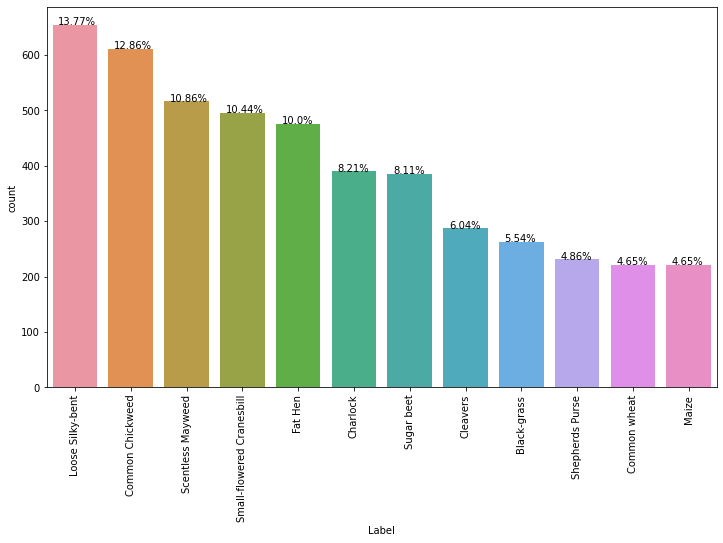

In [12]:
plt.figure(figsize = (12,7))
ax = sns.countplot(x = "Label", data = y, order =y["Label"].value_counts().index);    # countplot of labels
plt.xticks(rotation = 90);
for p in ax.patches:
    per = np.round(100 * p.get_height() / y.shape[0], 2)
    plt.annotate(str(per) + "%", (p.get_x() + p.get_width()/2 - 0.3, p.get_y() + p.get_height() + 0.1))

- The distribution of classes is not uniform. `Loose Silky-bent` accounts for 13.77% of the total, followed by `Common Chickweed` of 12.86%. `Common wheat` only accounts for 4.65%.

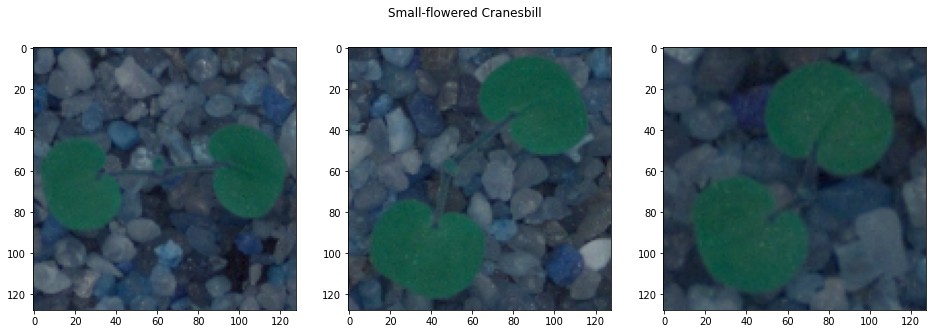

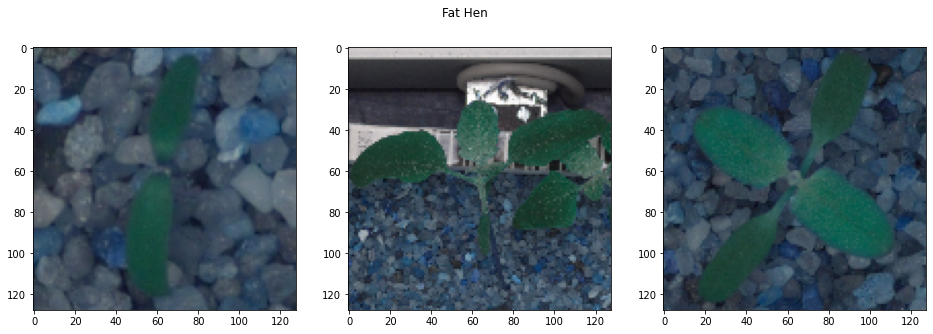

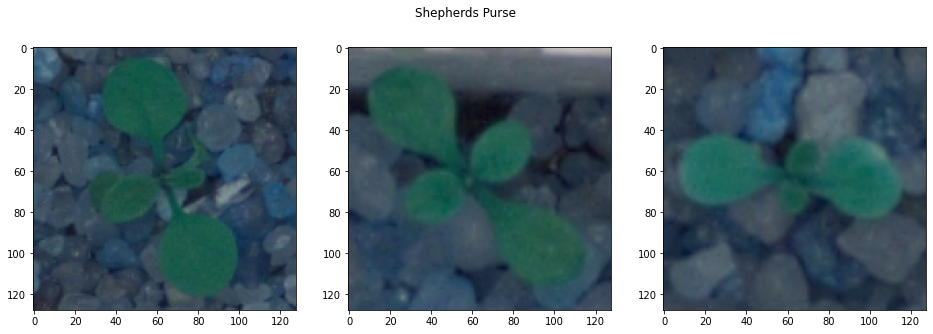

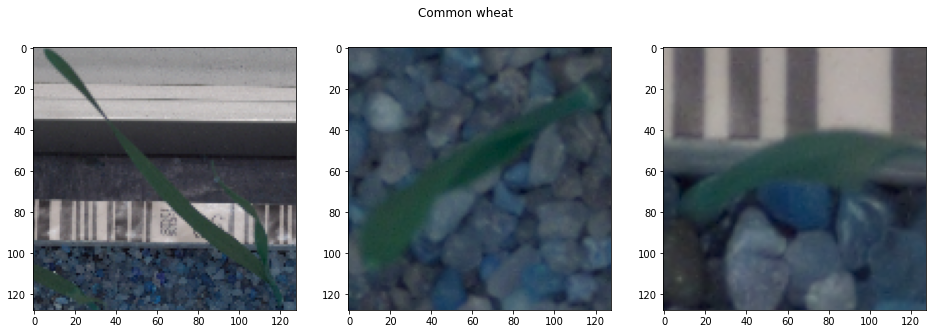

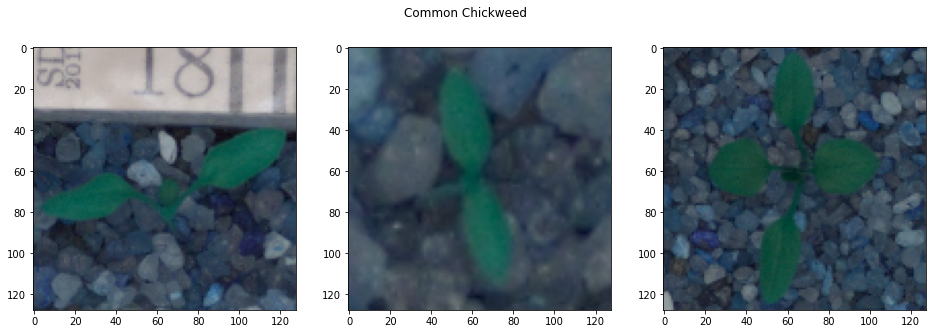

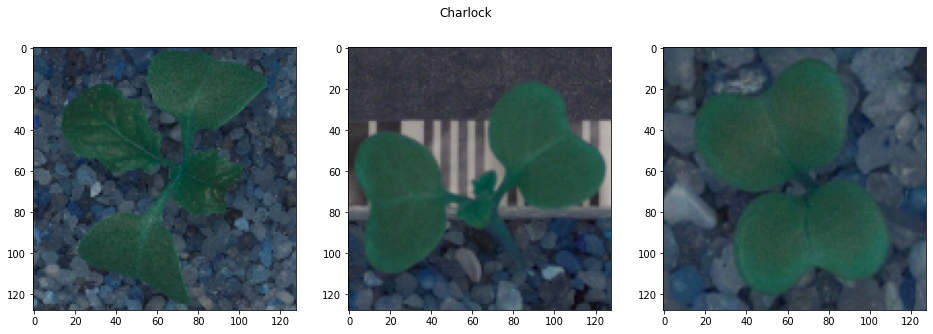

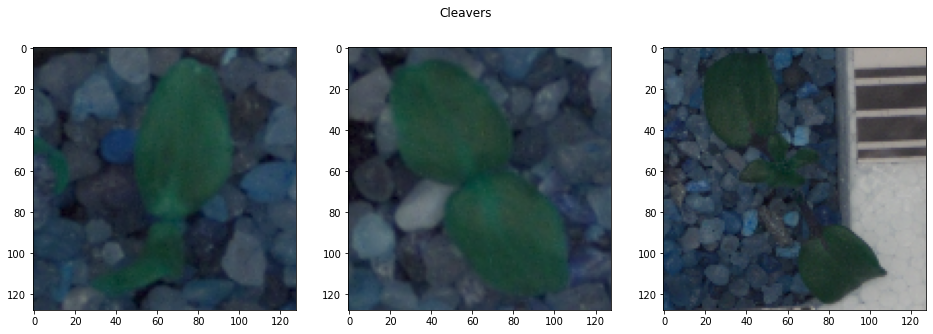

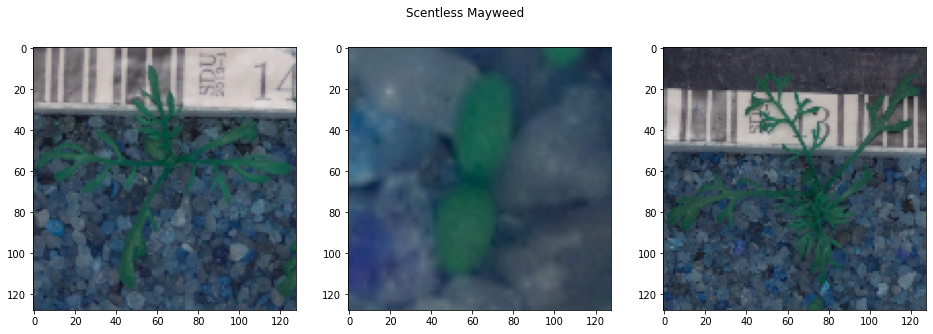

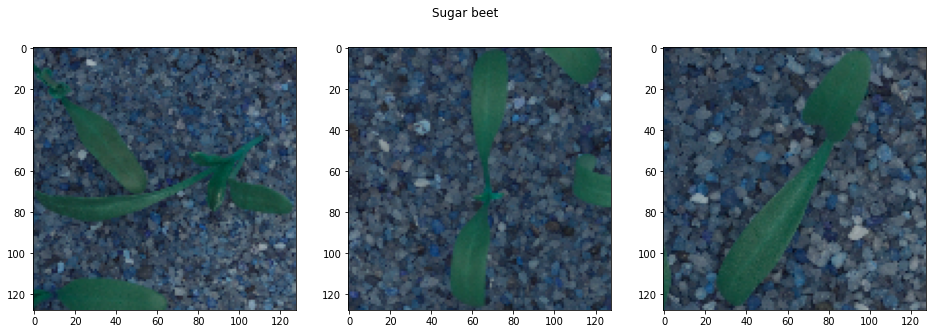

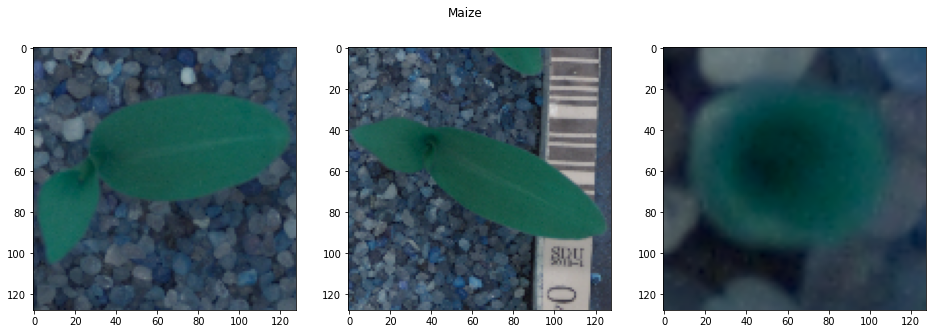

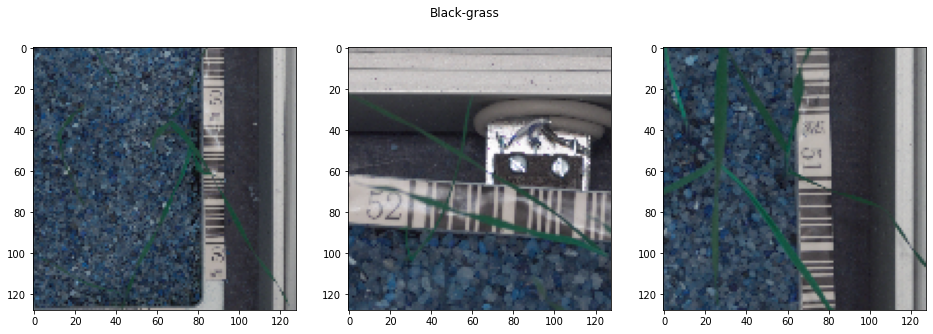

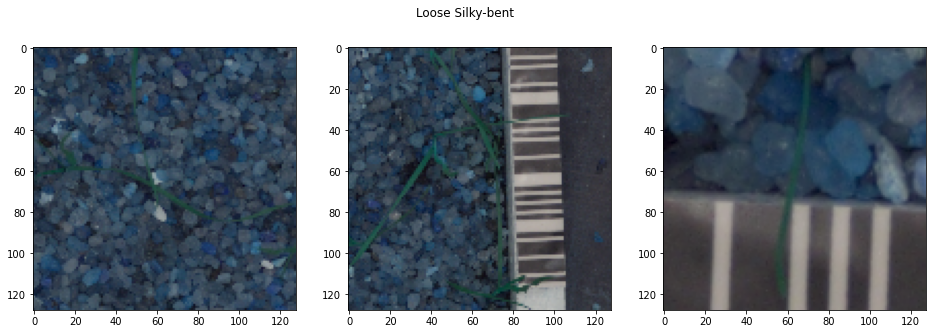

In [13]:
# Plot the images from each class and print their corresponding labels
for label in y["Label"].unique():
    idx = y[y.Label == label].index 
    plt.figure(figsize=(16,5))   # display 3 images for each class
    plt.subplot(131)
    plt.imshow(X[idx[0]]);
    plt.subplot(132)
    plt.imshow(X[idx[100]]);    
    plt.subplot(133)
    plt.imshow(X[idx[200]]);    
    plt.suptitle(label); 


- The images are colored. Width and height are both 128, with 3 channels.
- Some images are very blurry.

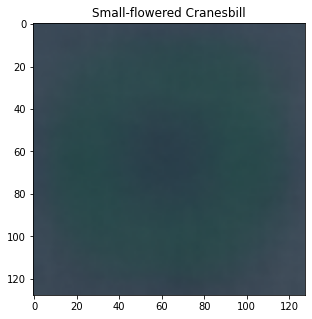

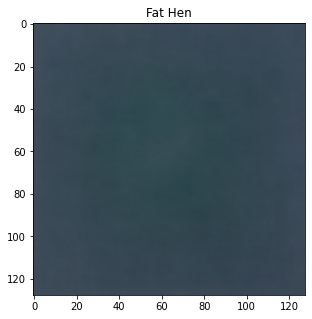

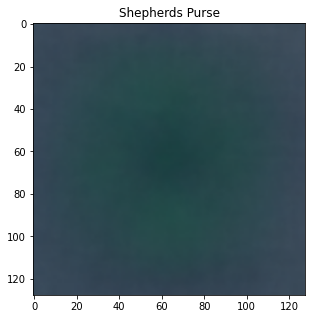

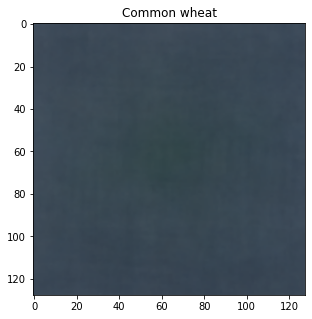

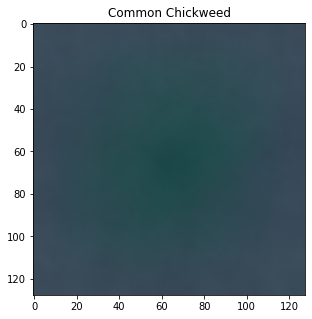

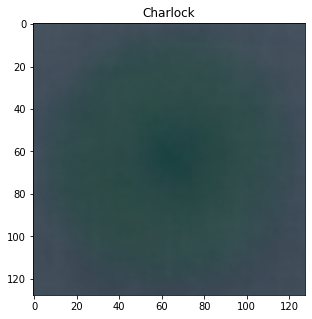

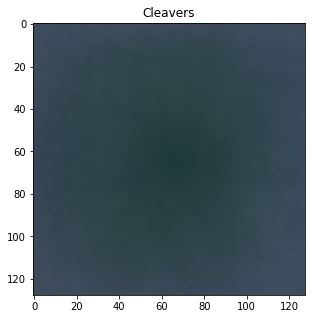

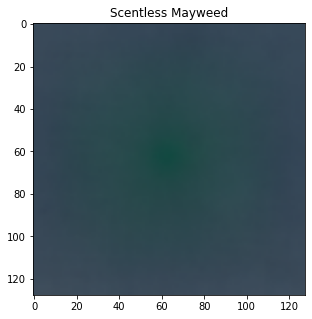

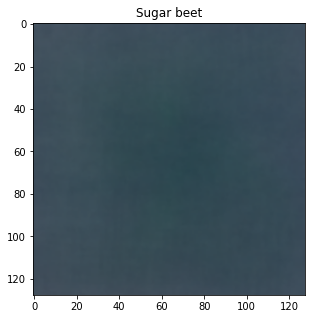

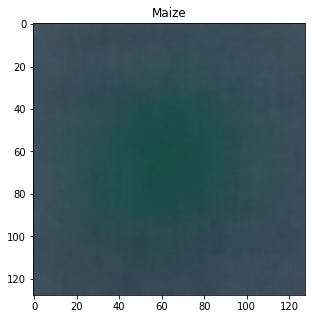

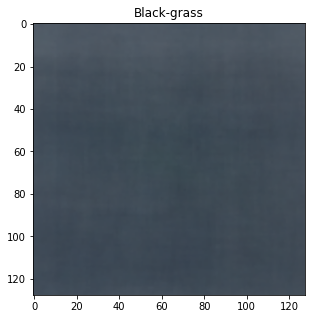

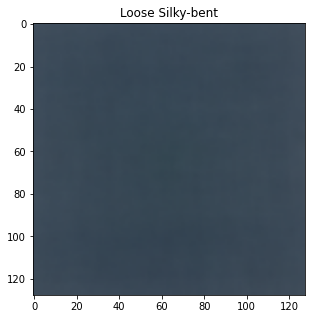

In [14]:
# Plot the mean images for each class
for label in y["Label"].unique():
    idx = y[y.Label == label].index # the indices of images corresponding to this class
    idx = np.array(idx)
    mean_img = np.mean(X[idx], axis = 0)
    mean_img = np.round(mean_img).astype("int32")
#     print(mean_img)
#     print()
    plt.figure(figsize=(5,5))
    plt.imshow(mean_img);
    plt.title(label);

- The mean images show different intensity patterns for each class.

# Data Pre-processing

## Gaussian Blurring
Apply gaussian blurring with a kernel of 13 x 13, standard deviation of 0, to smooth the images and reduce noise.

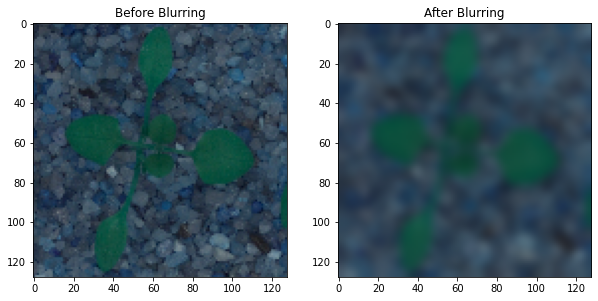

In [15]:
i = 1938   # check a random image after blurring, compare before and after side by side

plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(X[i])
plt.title("Before Blurring");

for j in range(len(X)):
    X[j] = cv2.GaussianBlur(src = X[j], ksize = (13,13), sigmaX = 0)
    
plt.subplot(122)
plt.imshow(X[i])
plt.title("After Blurring");

## Normalization

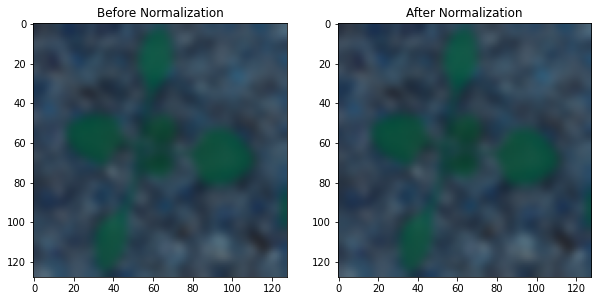

In [16]:
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(X[i])
plt.title("Before Normalization");

X = X.astype("float32") / 255.0

plt.subplot(122)
plt.imshow(X[i])    # plt.imshow() does denormalization internally
plt.title("After Normalization");

In [17]:
print("maximum after blurring:", X.max())
print("minimum after blurring:", X.min())

maximum after blurring: 0.98039216
minimum after blurring: 0.0


## Split Data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11, stratify = y, shuffle = True)
X_test, X_valid, y_test, y_valid= train_test_split(X_test, y_test, test_size = 0.5, random_state = 6, stratify = y_test, shuffle = True)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_valid.shape, y_valid.shape)
print("Test: ", X_test.shape, y_test.shape)

Train:  (3325, 128, 128, 3) (3325, 1)
Validation:  (713, 128, 128, 3) (713, 1)
Test:  (712, 128, 128, 3) (712, 1)


## Convert Labels to One-hot Encoding

In [19]:
y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)
y_test = pd.get_dummies(y_test)
y_train.head()

Label_Black-grass  Label_Charlock  Label_Cleavers  \
4275                  0               0               0   
4053                  1               0               0   
1286                  0               0               0   
2286                  0               1               0   
4239                  0               0               0   

      Label_Common Chickweed  Label_Common wheat  Label_Fat Hen  \
4275                       0                   0              0   
4053                       0                   0              0   
1286                       0                   1              0   
2286                       0                   0              0   
4239                       0                   0              0   

      Label_Loose Silky-bent  Label_Maize  Label_Scentless Mayweed  \
4275                       1            0                        0   
4053                       0            0                        0   
1286                       0            0                        0   
2286                       0            0                        0   
4239                       1            0                        0   

      Label_Shepherds Purse  Label_Small-flowered Cranesbill  Label_Sugar beet  
4275                      0                                0                 0  
4053                      0                                0                 0  
1286                      0                                0                 0  
2286                      0                                0                 0  
4239                      0                                0                 0

# Model Building

In [20]:
num_class = 12     # number of class
input_shape = (128, 128, 3)     # shape of each image

In [21]:
def history_loss(history):
    """
    Plot training history.
    """
    plt.figure(figsize = (20,5));

    plt.subplot(121);   # plot accuracy curve
    plt.plot(history.history["accuracy"], label = "train");
    plt.plot(history.history["val_accuracy"], label = "validation");
    plt.legend(loc = "lower right");
    plt.title("Accuracy");

    plt.subplot(122);    # plot loss curve
    plt.plot(history.history["loss"], label = "train");
    plt.plot(history.history["val_loss"], label = "validation");
    plt.legend(loc = "upper right");
    plt.title("Loss");

In [22]:
def show_confusion_matrix(y_true, y_pred, labels = y_train.columns.to_list()):
    """
    Show confusion matrix as heatmap.
    
    Input:
    y_true: ground truth of class.
    y_pred: predicted class.
    labels: class labels.
    
    Return:
    None.
    """
    matrix = confusion_matrix(y_true, y_pred)
    matrix_df = pd.DataFrame(matrix, columns = labels, index = labels)
    
    plt.figure(figsize = (8,7))
    sns.heatmap(matrix_df, annot = np.array([str(value) for value in matrix.flatten()]).reshape((num_class, num_class)),
                fmt='', cmap = "YlGnBu")
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')

In [23]:
def visualize_prediction(model):
    indices = [2, 3, 33, 36, 59]   # visualize some randomly chosen test images
    plt.figure(figsize = (16, 9)) 
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(X_test[idx])
        plt.title("Actual:" + str(y_true[idx]) + ", Predict: " + str(y_pred[idx]))

## Basic Model

In [24]:
def build_model_basic():
    model = keras.Sequential()
    # 1st conv + maxpooling
    model.add(Conv2D(filters = 64, kernel_size = 3, input_shape = input_shape, strides=1, padding='same', activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    # 2nd conv + maxpooling
    model.add(Conv2D(filters = 64, kernel_size = 5, strides=1, padding='same', activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 3nd conv
    model.add(Conv2D(filters = 64, kernel_size = 5, strides=1, padding='valid', activation="relu", kernel_initializer='he_normal'))
    
    # flatten the output of Conv
    model.add(Flatten())
    
    # fully connected NN with softmax output 
    model.add(Dense(units = 60, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.3))

    model.add(Dense(units = num_class, activation = "softmax", kernel_initializer="glorot_normal"))
    
    # compile with adam as optimizer and accuracy as metrics
    model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [25]:
m1 = build_model_basic()
es = EarlyStopping(monitor = "val_loss", patience = 3)
history = m1.fit(x = X_train,y = y_train, epochs = 50, verbose = 1, validation_data = (X_valid, y_valid), callbacks=[es])

Epoch 1/50
104/104 [==============================] - 106s 1s/step - loss: 1.9156 - accuracy: 0.3681 - val_loss: 3.5522 - val_accuracy: 0.1346
Epoch 2/50
104/104 [==============================] - 106s 1s/step - loss: 1.3868 - accuracy: 0.5438 - val_loss: 1.4114 - val_accuracy: 0.5358
Epoch 3/50
104/104 [==============================] - 115s 1s/step - loss: 1.1606 - accuracy: 0.6202 - val_loss: 1.3005 - val_accuracy: 0.6157
Epoch 4/50
104/104 [==============================] - 115s 1s/step - loss: 0.9962 - accuracy: 0.6794 - val_loss: 1.2311 - val_accuracy: 0.5961
Epoch 5/50
104/104 [==============================] - 108s 1s/step - loss: 0.8404 - accuracy: 0.7245 - val_loss: 1.4487 - val_accuracy: 0.5358
Epoch 6/50
104/104 [==============================] - 102s 984ms/step - loss: 0.7274 - accuracy: 0.7741 - val_loss: 1.0730 - val_accuracy: 0.6522
Epoch 7/50
104/104 [==============================] - 99s 957ms/step - loss: 0.6317 - accuracy: 0.8015 - val_loss: 0.9532 - val_accuracy: 0

In [26]:
m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 60)                3

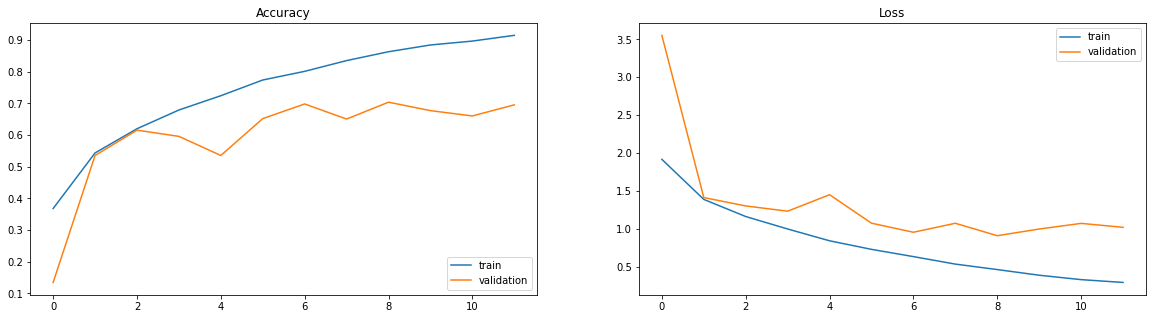

In [27]:
history_loss(history)

In [28]:
m1.evaluate(X_train, y_train)
m1.evaluate(X_valid, y_valid)
m1.evaluate(X_test, y_test)

23/23 [==============================] - 5s 232ms/step - loss: 0.9209 - accuracy: 0.7191


[0.9208846092224121, 0.7191011309623718]

- Accuracy and loss of validation set fluctuate along the training. Overfitting exists between the train set and validation/ test set. 

In [29]:
y_true = np.argmax(y_test.to_numpy(), axis = -1)   # convert one-hot output to label value

y_pred = m1.predict(X_test)
y_pred = np.argmax(y_pred, axis = -1)   # convert one-hot output to label value

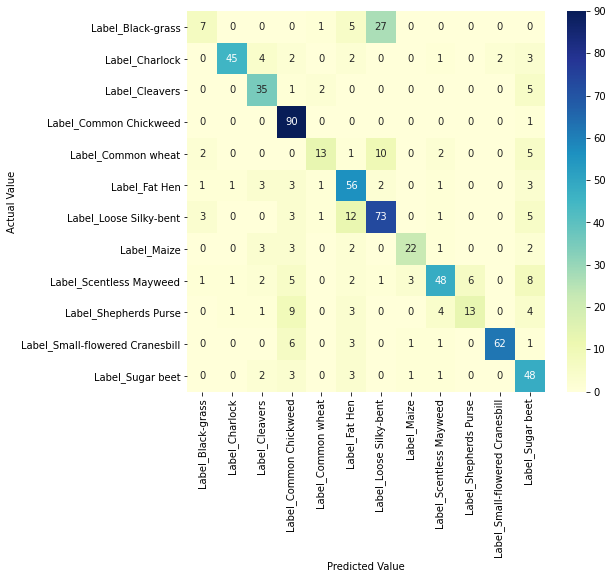

In [30]:
show_confusion_matrix(y_true, y_pred)

In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.17      0.26        40
           1       0.94      0.76      0.84        59
           2       0.70      0.81      0.75        43
           3       0.72      0.99      0.83        91
           4       0.72      0.39      0.51        33
           5       0.63      0.79      0.70        71
           6       0.65      0.74      0.69        98
           7       0.81      0.67      0.73        33
           8       0.80      0.62      0.70        77
           9       0.68      0.37      0.48        35
          10       0.97      0.84      0.90        74
          11       0.56      0.83      0.67        58

    accuracy                           0.72       712
   macro avg       0.72      0.67      0.67       712
weighted avg       0.73      0.72      0.71       712



- The metric we care about is the recall for each class. Based on the confusion matrix and classfification report, recalls for most categories are greater than 0.7, except those for class 0, 4, 7, 8, 9.
- Accuracy is not high enough.

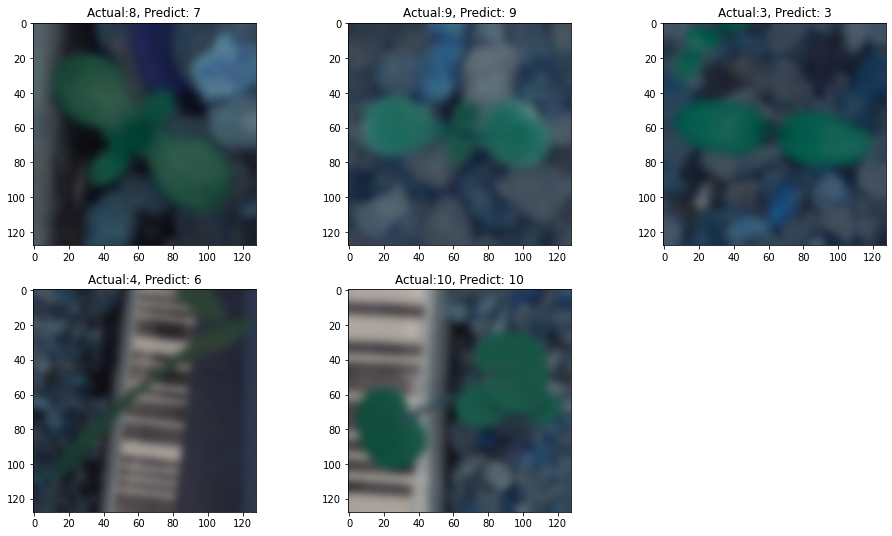

In [32]:
visualize_prediction(m1)

## Improvement with ImageDataGenerator

- ImageDataGenerator is a powerful preprocessing utility to generate training and testing data with common data augmentation techniques. It could reduce overfitting.

In [33]:
# implement rotation, shear, zooming, flipping
ig = ImageDataGenerator(rotation_range = 90, shear_range = 0.4, zoom_range = 0.4, horizontal_flip=True, vertical_flip=True) 

In [34]:
m2 = build_model_basic()
es = EarlyStopping(monitor = "val_loss", patience = 3)
history = m2.fit(x = ig.flow(X_train, y_train), epochs = 50, verbose = 1, validation_data = (X_valid, y_valid), callbacks=[es])

Epoch 1/50
104/104 [==============================] - 102s 972ms/step - loss: 2.0295 - accuracy: 0.3146 - val_loss: 7.8577 - val_accuracy: 0.1276
Epoch 2/50
104/104 [==============================] - 103s 985ms/step - loss: 1.6369 - accuracy: 0.4436 - val_loss: 1.7134 - val_accuracy: 0.4558
Epoch 3/50
104/104 [==============================] - 102s 978ms/step - loss: 1.4740 - accuracy: 0.5080 - val_loss: 2.0917 - val_accuracy: 0.3913
Epoch 4/50
104/104 [==============================] - 102s 984ms/step - loss: 1.3284 - accuracy: 0.5525 - val_loss: 1.5107 - val_accuracy: 0.5189
Epoch 5/50
104/104 [==============================] - 102s 981ms/step - loss: 1.2021 - accuracy: 0.5997 - val_loss: 1.7914 - val_accuracy: 0.4404
Epoch 6/50
104/104 [==============================] - 102s 976ms/step - loss: 1.0912 - accuracy: 0.6394 - val_loss: 1.9539 - val_accuracy: 0.3492
Epoch 7/50
104/104 [==============================] - 107s 1s/step - loss: 1.0207 - accuracy: 0.6626 - val_loss: 1.1668 - va

In [35]:
m2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)               

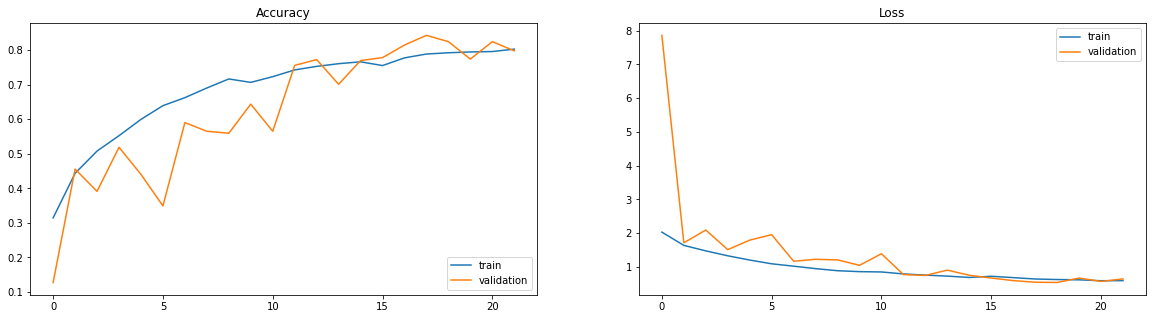

In [36]:
history_loss(history)

In [37]:
m2.evaluate(X_train, y_train)
m2.evaluate(X_valid, y_valid)
m2.evaluate(X_test, y_test)

23/23 [==============================] - 6s 258ms/step - loss: 0.5064 - accuracy: 0.8287


[0.5063843131065369, 0.8286516666412354]

- Overfitting is reduced significantly. Accuracy of train/ validation/ test set are alike.

In [38]:
y_pred = m2.predict(X_test)
y_pred = np.argmax(y_pred, axis = -1)   # convert one-hot output to label value

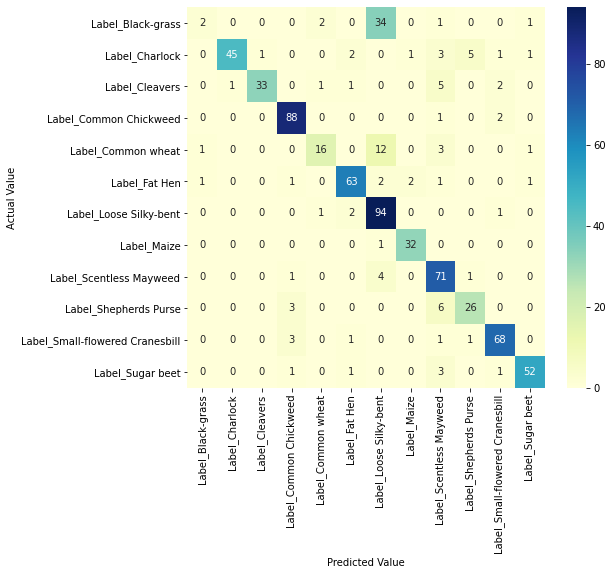

In [39]:
show_confusion_matrix(y_true, y_pred)

In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.05      0.09        40
           1       0.98      0.76      0.86        59
           2       0.97      0.77      0.86        43
           3       0.91      0.97      0.94        91
           4       0.80      0.48      0.60        33
           5       0.90      0.89      0.89        71
           6       0.64      0.96      0.77        98
           7       0.91      0.97      0.94        33
           8       0.75      0.92      0.83        77
           9       0.79      0.74      0.76        35
          10       0.91      0.92      0.91        74
          11       0.93      0.90      0.91        58

    accuracy                           0.83       712
   macro avg       0.83      0.78      0.78       712
weighted avg       0.83      0.83      0.81       712



- Accuracy is improved from 0.72 to 0.83.
- Recalls for class 0, 4 are below 0.7. Anothers are greater than 0.7. The number of categories with bad recall is reduced significantly.

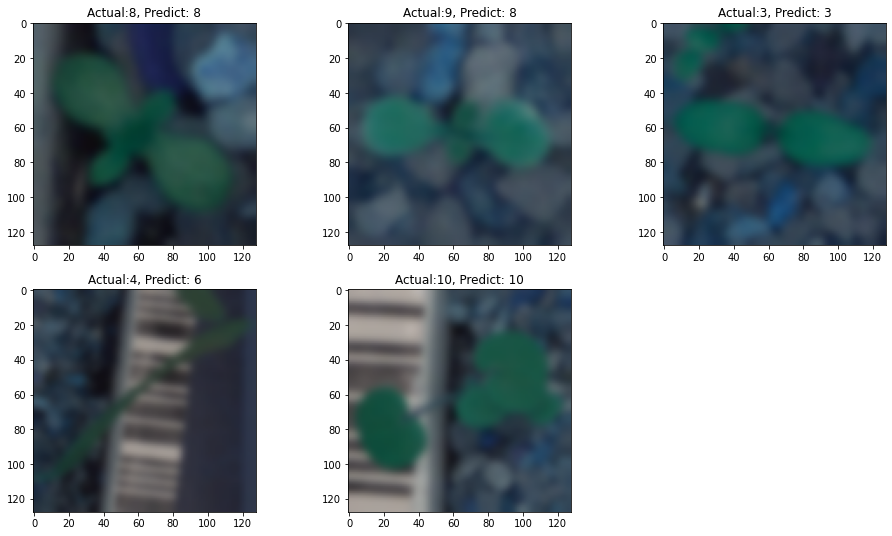

In [41]:
visualize_prediction(m2)